In [61]:
import xgboost as xgb
from catboost import CatBoostClassifier
from sklearn import preprocessing 
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, GridSearchCV
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer,KNNImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import LocalOutlierFactor
from  sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.manifold import TSNE

# Download data

In [28]:
data = pd.read_csv('./data/orange_small_churn_train_data.csv')

In [29]:
data.head()

,ID,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,...,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230,labels
0,0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,...,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN,-1.0
1,1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,...,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN,-1.0
2,2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,...,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN,-1.0
3,3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,...,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN,1.0
4,4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,...,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN,-1.0


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18299 entries, 0 to 18298
Columns: 232 entries, ID to labels
dtypes: float64(192), int64(2), object(38)
memory usage: 32.4+ MB


In [31]:
# check null in features
dict_nan = {name: np.sum(data[name].isnull()) for name in data.columns}
dict_nan

{'ID': 0,
 'Var1': 18038,
 'Var2': 17831,
 'Var3': 17832,
 'Var4': 17736,
 'Var5': 17799,
 'Var6': 1991,
 'Var7': 1976,
 'Var8': 18299,
 'Var9': 18038,
 'Var10': 17799,
 'Var11': 17832,
 'Var12': 18085,
 'Var13': 1976,
 'Var14': 17832,
 'Var15': 18299,
 'Var16': 17799,
 'Var17': 17736,
 'Var18': 17736,
 'Var19': 17736,
 'Var20': 18299,
 'Var21': 1991,
 'Var22': 1792,
 'Var23': 17799,
 'Var24': 2616,
 'Var25': 1792,
 'Var26': 17799,
 'Var27': 17799,
 'Var28': 1793,
 'Var29': 18038,
 'Var30': 18038,
 'Var31': 18299,
 'Var32': 18299,
 'Var33': 18010,
 'Var34': 17831,
 'Var35': 1792,
 'Var36': 17831,
 'Var37': 17736,
 'Var38': 1792,
 'Var39': 18299,
 'Var40': 17831,
 'Var41': 18038,
 'Var42': 18299,
 'Var43': 17831,
 'Var44': 1792,
 'Var45': 18171,
 'Var46': 17831,
 'Var47': 18038,
 'Var48': 18299,
 'Var49': 17831,
 'Var50': 18038,
 'Var51': 16888,
 'Var52': 18299,
 'Var53': 18038,
 'Var54': 17831,
 'Var55': 18299,
 'Var56': 18055,
 'Var57': 0,
 'Var58': 18038,
 'Var59': 17990,
 'Var60': 1

In [32]:
# check disbalance in classes
print(data['labels'].value_counts())
print(data['labels'].unique())

-1.0    16921
 1.0     1377
Name: labels, dtype: int64
[-1.  1. nan]


In [33]:
data['labels'].replace(-1, 0, inplace=True)
data.dropna(subset=['labels'], inplace=True)
labels = data['labels']
data = data.iloc[:,:-1]

# Simple preprocessing feature

In [34]:
# drop feture with null more half of dataset
def check_feat_without(data, columns, threshold = 0):
    flag_nan_col = [np.sum(data[name].isnull()) < threshold for name in columns]
    return columns[flag_nan_col]
    

In [35]:
numeric_col = data.columns[1:190]
cat_col = data.columns[190:]
print(len(numeric_col))
print(len(cat_col))

189
41


In [36]:
right_numeric_column = check_feat_without(data, numeric_col, threshold = len(data)//2)
right_cat_column = check_feat_without(data, cat_col, threshold = len(data)//2)
print(len(right_numeric_column))
print(len(right_cat_column))

41
28


In [37]:
# check unique in cat feat
for cur_cat in right_cat_column:
    count_uniq = len(data[cur_cat].unique())
    print(f'{cur_cat}: {count_uniq}')

Var192: 326
Var193: 44
Var195: 21
Var196: 4
Var197: 207
Var198: 2721
Var199: 2639
Var202: 4673
Var203: 4
Var204: 100
Var205: 4
Var206: 22
Var207: 12
Var208: 3
Var210: 6
Var211: 2
Var212: 71
Var216: 1247
Var217: 7944
Var218: 3
Var219: 20
Var220: 2721
Var221: 7
Var222: 2721
Var223: 5
Var226: 23
Var227: 7
Var228: 29


In [38]:
# check unique in num feat
for cur_num in right_numeric_column:
    count_uniq = len(data[cur_num].unique())
    print(f'{cur_num}: {count_uniq}')

Var6: 1039
Var7: 7
Var13: 1877
Var21: 498
Var22: 498
Var24: 63
Var25: 190
Var28: 2513
Var35: 10
Var38: 11908
Var44: 6
Var57: 14013
Var65: 13
Var72: 9
Var73: 129
Var74: 284
Var76: 11377
Var78: 13
Var81: 15952
Var83: 130
Var85: 109
Var94: 8571
Var109: 149
Var112: 158
Var113: 17900
Var119: 1003
Var123: 191
Var125: 6217
Var126: 52
Var132: 18
Var133: 14165
Var134: 12639
Var140: 1859
Var143: 5
Var144: 11
Var149: 7524
Var153: 14567
Var160: 273
Var163: 9049
Var173: 4
Var181: 7


In [39]:
# check nan in rows, drop rows with count nan more half of features
data = data[np.union1d(right_numeric_column, right_cat_column)]

In [43]:
index_total_nan = [sum(i)/len(np.union1d(right_numeric_column, right_cat_column)) < 0.5 for i in data.isnull().to_numpy()]

In [41]:
data = data.loc[index_total_nan]
labels = labels.loc[index_total_nan]

In [42]:
labels.value_counts()

0.0    15215
1.0     1291
Name: labels, dtype: int64

In [47]:
# use simple label encoder for cat feature, but it can wrong  a bit because it give us order in feature but we will use it 
# use standard scaler for numeric
# fill nan by mean

# Prerocessing numeric features
numeric_data = data[right_numeric_column]

# fill on null by mean
mean_data = numeric_data.mean(axis='index')

for i, name in enumerate(right_numeric_column):
    numeric_data[name].fillna(mean_data[i], inplace=True)
    
scaler = StandardScaler().fit(numeric_data)
scaled_numeric_data = scaler.transform(numeric_data)

In [48]:
# Preprocessing cat features
cat_data = data[right_cat_column]
transform_cat_data = cat_data.copy()
dict_encoders = dict()
for name in cat_data.columns:
    unique_val = np.append(cat_data[name].unique(), 'unk_val')
    encoder_cur = LabelEncoder().fit(unique_val)
    dict_encoders[name] = encoder_cur
    transform_cat_data[name] = encoder_cur.transform(cat_data[name])

In [49]:
data_anomaly = np.hstack([scaled_numeric_data, transform_cat_data.to_numpy()])

ways to determine anomalies

In [85]:
# OneClassSVM
anomaly_svd = OneClassSVM(nu=0.2).fit_predict(data_anomaly)

In [86]:
print(sum(anomaly_svd == 1))
print(sum(anomaly_svd == -1))

13204
3302


In [87]:
upset_data = TSNE(2).fit_transform(data_anomaly)

In [89]:
def plotting_tsne(data, labels):
    plt.figure(figsize=(20,20))
    plt.scatter(data[:,0], data[:,1], cmap='winter_r', c=labels)

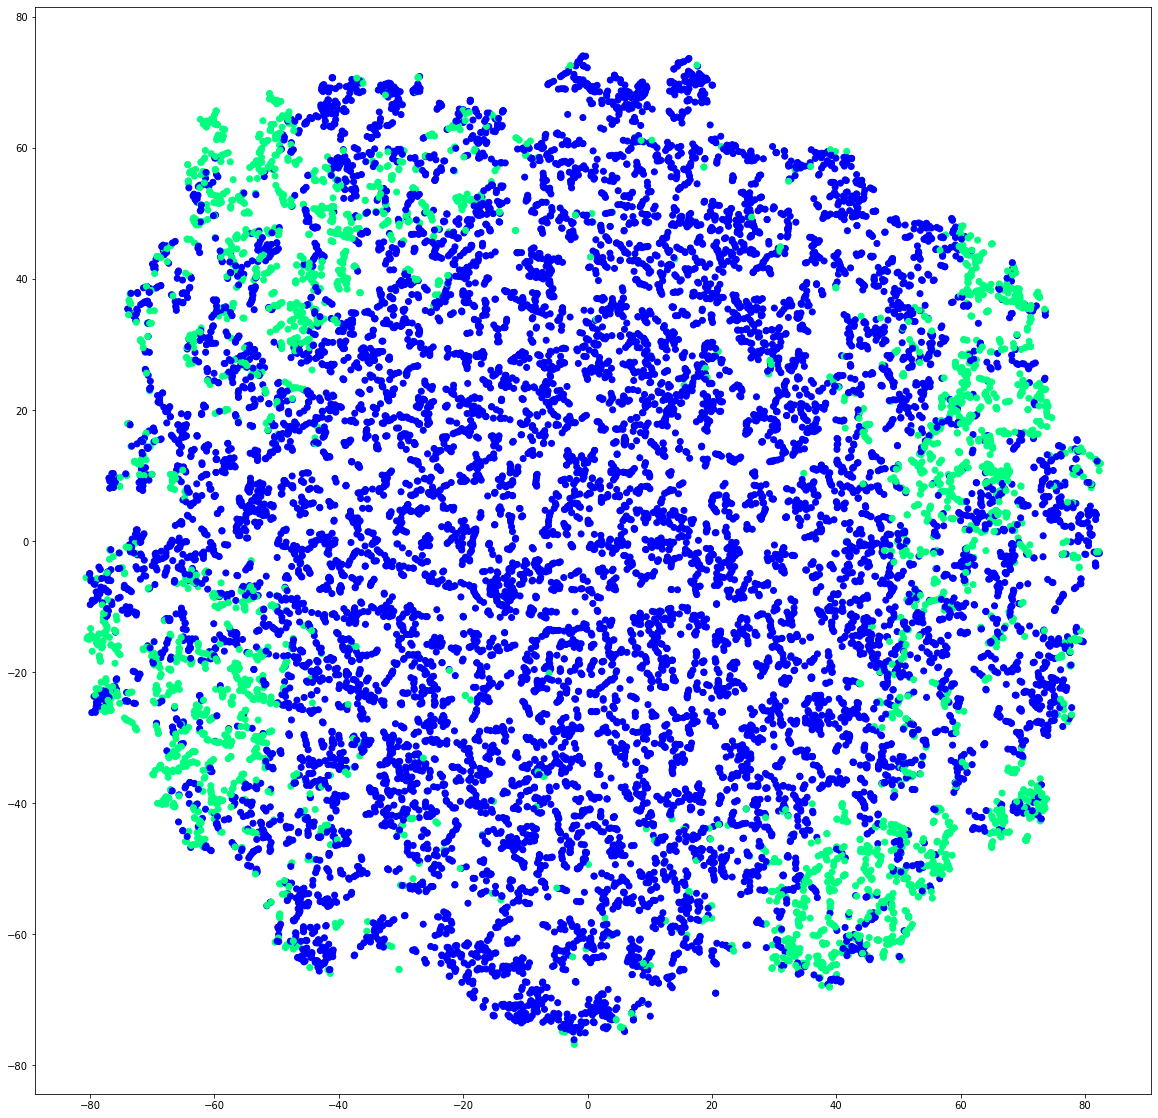

In [90]:
plotting_tsne(upset_data, anomaly_svd)

In [91]:
# IsolationForest
anomaly_is = IsolationForest().fit_predict(data_anomaly)

In [92]:
print(sum(anomaly_is == 1))
print(sum(anomaly_is == -1))

16034
472


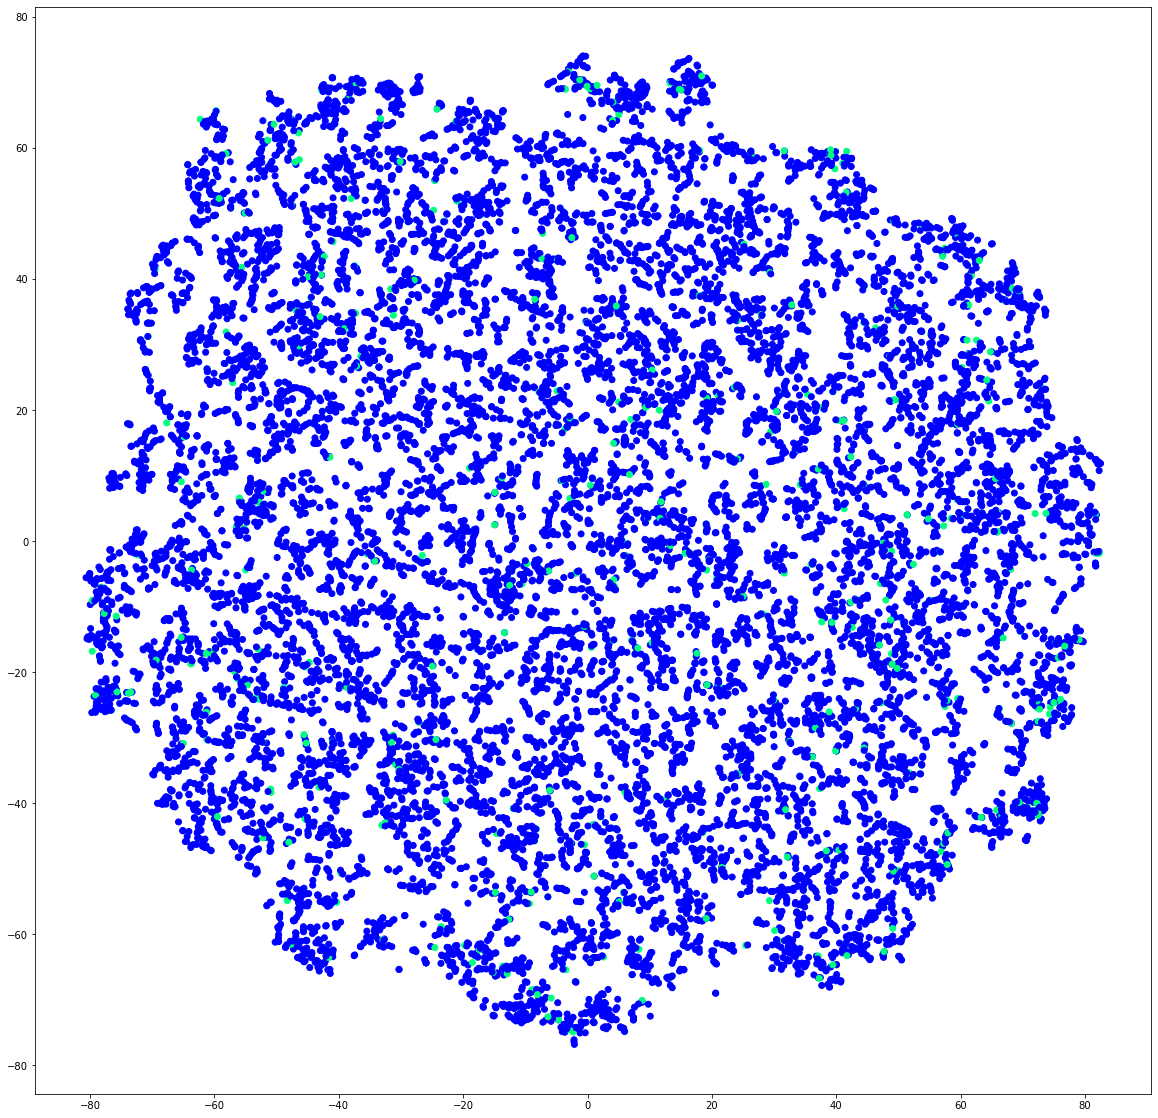

In [98]:
plotting_tsne(upset_data, anomaly_is)

In [95]:
# LOF
anomaly_lof = LocalOutlierFactor().fit_predict(data_anomaly)

In [96]:
print(sum(anomaly_lof == 1))
print(sum(anomaly_lof == -1))

16506
0


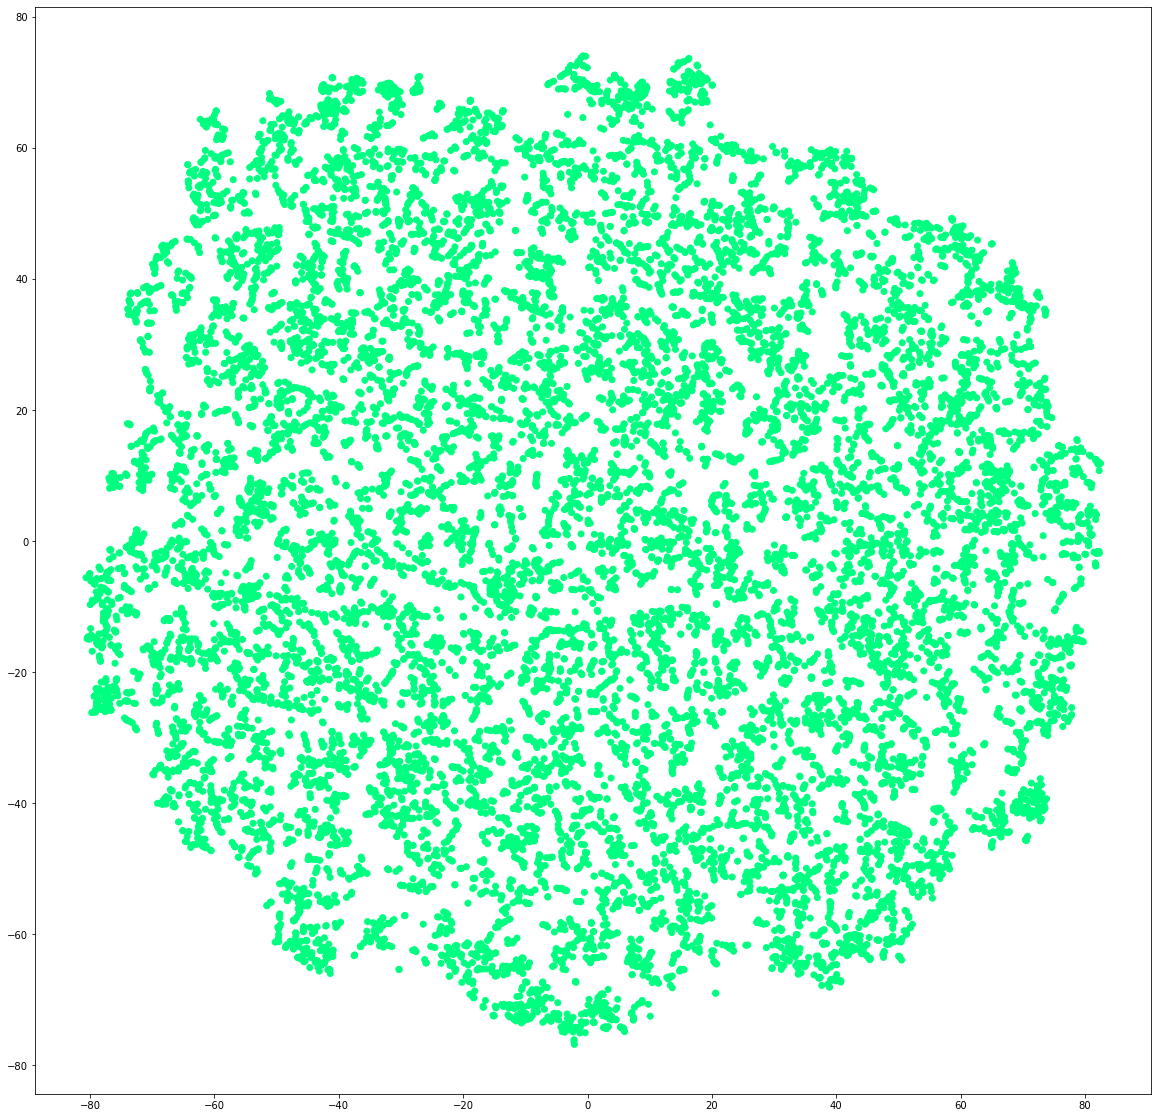

In [99]:
plotting_tsne(upset_data, anomaly_lof)

we've got next results. method svd is makes mistakes more than isolation forest and lof, because parameter nu indluence to quality algo. It seems that this data doesnt have anomaly but we can check several points from isolation forest and compare with all data 

In [114]:
# compare anomaly wih mean feature
index_anomaly_is = np.where(anomaly_is == -1)
data_anomaly = pd.DataFrame(data_anomaly, columns = np.union1d(right_numeric_column, right_cat_column))
data_anomaly_check = data_anomaly[data_anomaly.index.isin(index_anomaly_is[0])] 
data_normal_check = data_anomaly[~data_anomaly.index.isin(index_anomaly_is[0])] 

In [115]:
data_anomaly_check

,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var13,Var132,Var133,...,Var7,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94
11,-0.346861,1.153681,1.700532,-0.298270,-0.293592,-0.434755,-0.419421,0.671395,-0.248060,-0.832118,...,5805.0,1.0,10.0,218.0,7.0,1658.0,0.0,0.0,3.0,24.0
19,1.086210,0.033425,1.537106,0.291483,0.295641,0.330669,-0.077188,-0.614015,-0.248060,-0.725699,...,6944.0,1.0,10.0,459.0,0.0,482.0,0.0,6.0,0.0,10.0
88,-0.026799,1.153681,14.440328,0.013952,0.018355,-0.052043,-0.343369,0.754407,1.465829,2.578548,...,7366.0,3.0,10.0,218.0,4.0,1658.0,0.0,10.0,3.0,14.0
124,0.102956,1.153681,1.932300,0.256792,0.260980,0.522025,0.150968,1.031686,-0.248060,0.498915,...,936.0,1.0,10.0,218.0,4.0,1658.0,1.0,10.0,3.0,9.0
168,0.754614,1.153681,1.229569,0.596768,0.600656,1.478805,0.227020,-0.768059,4.893606,0.913131,...,1473.0,1.0,10.0,680.0,4.0,711.0,3.0,18.0,2.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16241,18.706931,1.153681,0.308440,3.330449,3.331927,2.435585,1.519900,-0.256291,-0.248060,-0.222467,...,100.0,1.0,10.0,543.0,4.0,1515.0,1.0,12.0,2.0,7.0
16251,7.412484,1.153681,-0.410634,6.556747,6.555380,6.454059,4.143688,0.459157,-0.248060,0.542534,...,1806.0,0.0,10.0,2199.0,4.0,1794.0,0.0,23.0,2.0,7.0
16288,-0.202689,-1.086831,-0.462633,1.248966,1.252279,0.330669,1.976211,0.316238,4.893606,0.802053,...,7066.0,1.0,18.0,2545.0,4.0,118.0,0.0,14.0,2.0,7.0
16412,0.688295,0.033425,-0.324464,-0.187258,-0.182678,-0.434755,-0.267317,0.459157,-0.248060,2.146429,...,2379.0,0.0,10.0,640.0,0.0,2388.0,1.0,1.0,0.0,10.0


In [117]:
data_normal_check.describe()

,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var13,Var132,Var133,...,Var7,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94
count,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,...,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000,16034.000000
mean,-0.051748,-0.023339,-0.024087,-0.074184,-0.074231,-0.065273,-0.068640,-0.003717,-0.019100,-0.002150,...,3664.506486,0.548148,10.941312,1194.651054,4.125047,1280.778471,0.859486,10.170575,2.145753,9.481976
std,0.766780,0.967959,0.929147,0.326913,0.328353,0.524028,0.531158,0.990893,0.947859,1.004447,...,2145.427019,0.579022,3.040751,746.451802,1.388988,704.857527,1.603620,5.883357,0.924060,6.591034
min,-0.537169,-1.086831,-0.462633,-0.409283,-0.404507,-0.434755,-0.457447,-3.111235,-0.248060,-0.854690,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-0.326677,-1.086831,-0.462633,-0.215011,-0.224271,-0.434755,-0.381395,-0.614015,-0.248060,-0.852406,...,1754.250000,0.000000,10.000000,489.000000,4.000000,663.000000,0.000000,6.000000,2.000000,7.000000
50%,-0.188272,0.033425,-0.374977,-0.159505,-0.154949,-0.243399,-0.229291,-0.041486,-0.248060,-0.454825,...,3660.000000,1.000000,10.000000,1204.000000,4.000000,1360.000000,0.000000,10.000000,2.000000,7.000000
75%,0.022219,0.033425,0.098587,-0.013801,-0.023238,0.139313,0.074916,0.453808,-0.248060,0.649528,...,5474.750000,1.000000,10.000000,1823.000000,4.000000,1799.000000,1.000000,14.000000,2.000000,9.000000
max,46.454304,4.514449,29.722141,6.633068,6.631634,9.707110,16.578159,19.362034,13.463049,5.181000,...,7366.000000,3.000000,20.000000,2565.000000,7.000000,2565.000000,5.000000,23.000000,7.000000,29.000000


method based on distribution density